### Prediction models with Retention data, wind, ratio between reed belt and total estuary perimeter. 

In [1]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import mean_absolute_error, r2_score

In [3]:
data = {
    "Condition": [1, 2, 3, 4, 5, "EW", 1, 2, 3, 4, 5, "EW"],
    "Estuary": ["Warnow"] * 6 + ["Greifswald"] * 6,
    "Wind_Speed": [4.89, 3.0, 4.88, 2.76, 3.39, 4.61]*2,
    "Wind_Direction": [292.9, 72.87, 295.39, 192.06, 116.93, 266.07]*2,
    "Trapped": [97.4, 96.2, 61.3, 93.3, 96.4, 97.7, 14.1, 2.5, 14.4, 36.5, 5.9, 16.6],
    "Free": [2.6, 3.8, 38.7, 6.7, 3.6, 2.7, 85.9, 97.5, 85.6, 63.5, 94.1, 83.4],
    "Reed_Perimeter": [15.52]*6 + [303.83]*6,
    "Estuary_Perimeter": [82.71]*6 + [465.21]*6,
    "Ratio": [0.19]*6 + [0.65]*6
}
df = pd.DataFrame(data)


X = df[["Ratio", "Wind_Speed", "Wind_Direction"]]
y = df["Trapped"]

# --- Models ---
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "KNN (k=3)": KNeighborsRegressor(n_neighbors=3)
}

# --- Evaluation ---
results = {}
loo = LeaveOneOut()

for name, model in models.items():
    predictions, actuals = [], []
    
    for train_idx, test_idx in loo.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        model.fit(X_train, y_train)
        pred = model.predict(X_test)
        
        predictions.append(pred[0])
        actuals.append(y_test.values[0])
    
    mae = mean_absolute_error(actuals, predictions)
    r2 = r2_score(actuals, predictions)
    results[name] = {"MAE": round(mae, 2), "R²": round(r2, 2)}

# --- print results ---
print("Model Comparison:")
for name, metrics in results.items():
    print(f"{name:20s} | MAE: {metrics['MAE']:>5} | R²: {metrics['R²']}")


Model Comparison:
Linear Regression    | MAE: 14.03 | R²: 0.82
Decision Tree        | MAE: 12.46 | R²: 0.75
Random Forest        | MAE: 11.66 | R²: 0.82
KNN (k=3)            | MAE: 50.26 | R²: -0.73


/tmp/ipykernel_18310/844066673.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=metrics_df, x='Model', y='MAE', palette='coolwarm')
/tmp/ipykernel_18310/844066673.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=metrics_df, x='Model', y='R²', palette='viridis')


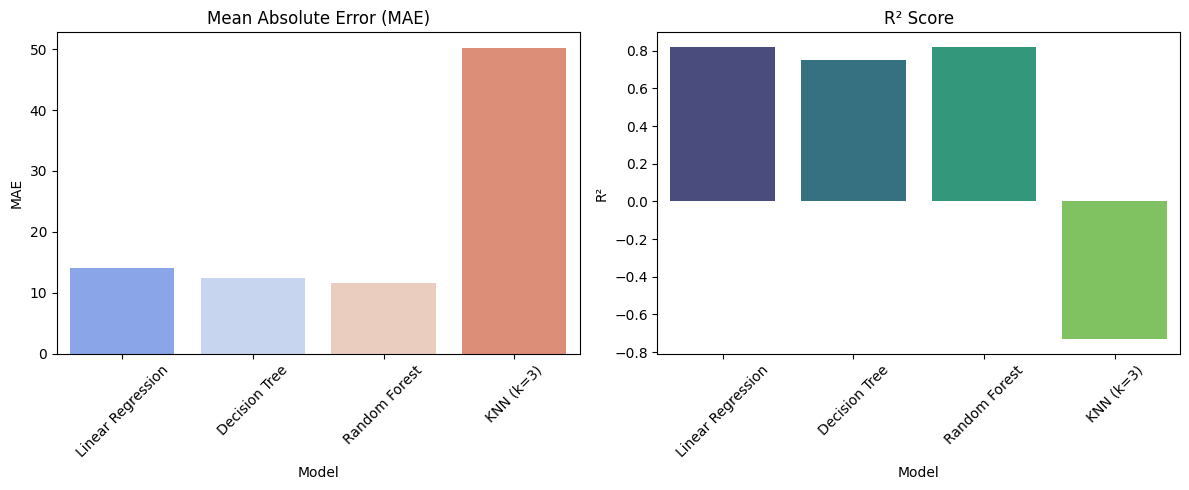

In [4]:
#Model performance visually (bar chart)
#Inspect feature importance

import matplotlib.pyplot as plt
import seaborn as sns

# --- Plot MAE and R² for each model ---
metrics_df = pd.DataFrame(results).T.reset_index().rename(columns={'index': 'Model'})

plt.figure(figsize=(12, 5))

# Plot MAE
plt.subplot(1, 2, 1)
sns.barplot(data=metrics_df, x='Model', y='MAE', palette='coolwarm')
plt.title('Mean Absolute Error (MAE)')
plt.ylabel('MAE')
plt.xticks(rotation=45)

# Plot R²
plt.subplot(1, 2, 2)
sns.barplot(data=metrics_df, x='Model', y='R²', palette='viridis')
plt.title('R² Score')
plt.ylabel('R²')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


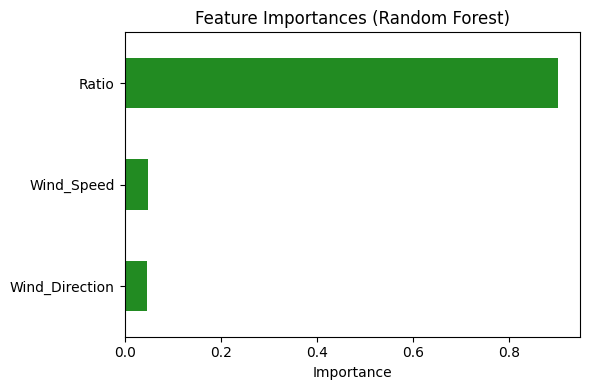

In [5]:
# --- Feature importances from Random Forest ---
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X, y)

importances = pd.Series(rf_model.feature_importances_, index=X.columns).sort_values(ascending=True)

plt.figure(figsize=(6, 4))
importances.plot(kind='barh', color='forestgreen')
plt.title('Feature Importances (Random Forest)')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

In [7]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [8]:
# Build the GLM
formula = "Trapped ~ Wind_Speed + Wind_Direction + Ratio"
#formula = "Trapped ~ Ratio"
model = smf.glm(formula=formula, data=df, family=sm.families.Gaussian()).fit()

# Summary
print(model.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:                Trapped   No. Observations:                   12
Model:                            GLM   Df Residuals:                        8
Model Family:                Gaussian   Df Model:                            3
Link Function:               Identity   Scale:                          171.88
Method:                          IRLS   Log-Likelihood:                -45.475
Date:                Fri, 16 May 2025   Deviance:                       1375.0
Time:                        11:07:35   Pearson chi2:                 1.38e+03
No. Iterations:                     3   Pseudo R-squ. (CS):             0.9998
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept        147.6618     20.853      7.

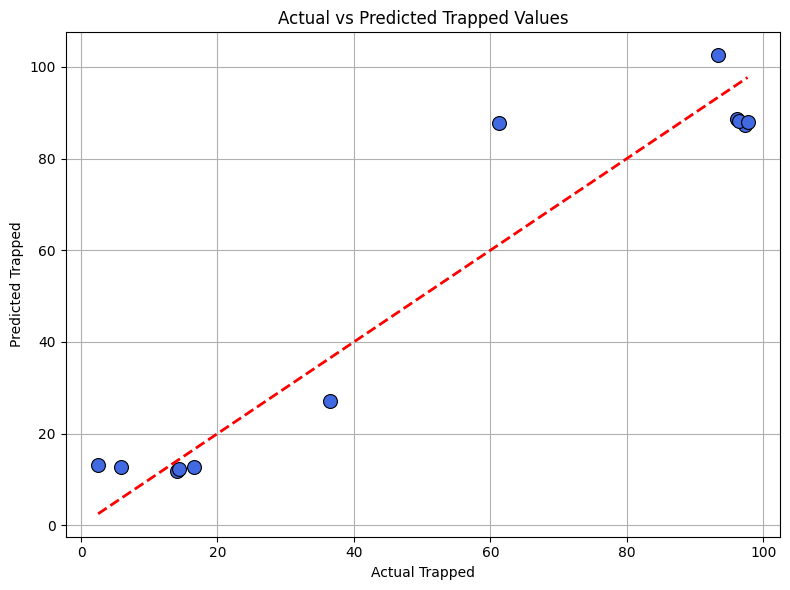

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Predict using the fitted GLM model
df['Predicted'] = model.predict()

# Plot: Actual vs Predicted
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Trapped', y='Predicted', data=df, s=100, color='royalblue', edgecolor='black')
plt.plot([df['Trapped'].min(), df['Trapped'].max()],
         [df['Trapped'].min(), df['Trapped'].max()],
         color='red', linestyle='--', linewidth=2)  # Line of perfect prediction
plt.xlabel('Actual Trapped')
plt.ylabel('Predicted Trapped')
plt.title('Actual vs Predicted Trapped Values')
plt.grid(True)
plt.tight_layout()
plt.show()


In [11]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import mean_absolute_error, r2_score


# Define features and target
X = df[["Ratio", "Wind_Speed", "Wind_Direction"]]
y = df["Trapped"]

# Initialize model
model = LinearRegression()

# Cross-validation (Leave-One-Out due to small size)
loo = LeaveOneOut()
predictions = []
actuals = []

for train_idx, test_idx in loo.split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    predictions.append(y_pred[0])
    actuals.append(y_test.values[0])

# Evaluate model
mae = mean_absolute_error(actuals, predictions)
r2 = r2_score(actuals, predictions)

print(f"Mean Absolute Error: {mae:.2f}")
print(f"R² Score: {r2:.2f}")

Mean Absolute Error: 14.03
R² Score: 0.82


In [12]:
print("Intercept:", model.intercept_)
print("Coefficients:")
for name, coef in zip(X.columns, model.coef_):
    print(f"{name}: {coef:.2f}")

Intercept: 149.3426319268383
Coefficients:
Ratio: -165.70
Wind_Speed: -11.91
Wind_Direction: 0.09


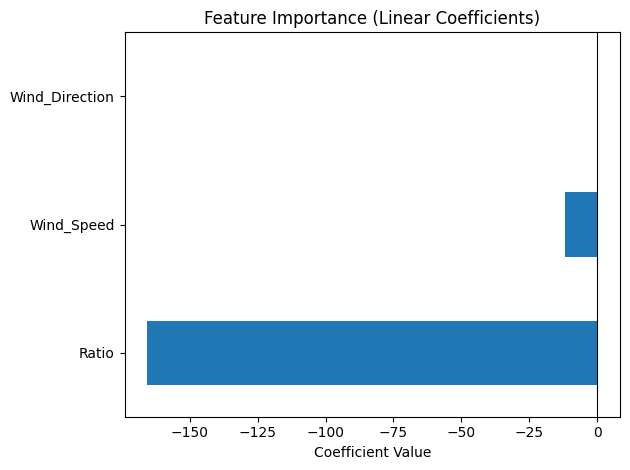

In [13]:
import matplotlib.pyplot as plt

coef_series = pd.Series(model.coef_, index=X.columns)
coef_series.plot(kind='barh')
plt.title("Feature Importance (Linear Coefficients)")
plt.xlabel("Coefficient Value")
plt.axvline(0, color='black', linewidth=0.8)
plt.tight_layout()
plt.show()
